In [294]:
import pandas as pd
from pandas import Series, DataFrame
import sqlite3
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sb
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn import decomposition
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.ensemble import RandomForestRegressor
from sklearn.covariance import EllipticEnvelope

# Sql query

# Saving sql db file to a pandas dataframe file 

In [147]:
def sql_to_pd(path):
    connect = sqlite3.connect(path)
    data = pd.DataFrame(pd.read_sql("SELECT * FROM survive", connect))
    return data

df = sql_to_pd('/Users/SY_Bl/Desktop/survive.db') #change out path for code to run

# Dataset Preprocessing

#### Dropping NaN values along with their respective indexes

 there are only about 500 NaN values under 'Creatinine' compared to the 15,000 values the dataset contains, so we can ignore them as they dont affect the validity of our dataset

In [148]:
df.isnull().sum()

ID                            0
Survive                       0
Gender                        0
Smoke                         0
Diabetes                      0
Age                           0
Ejection Fraction             0
Sodium                        0
Creatinine                  499
Pletelets                     0
Creatinine phosphokinase      0
Blood Pressure                0
Hemoglobin                    0
Height                        0
Weight                        0
Favorite color                0
dtype: int64

In [149]:
def remove_nan_values(data):
    if data.isnull().values.any() == True:
        data_drop = data.dropna() #drop NaN values
        data_drop_index = data_drop.reset_index(drop=True)
        return data_drop_index
    else:
        return data
    
df_NaN_removed = remove_nan_values(df)

#### Function to remove selected columns
Favourite colour seems to be the most inrelevant variable in predicting for coronary artery disease

In [150]:
def drop_columns(data, column_names):
    for name in column_names:
        data = data.drop([name], axis=1) #drop specific columns using the column_name
    return data

#removal of unique ID to facilitate machine learning 
df_dropped = drop_columns(df_NaN_removed, ['Favorite color','ID']) 
df_dropped

,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight
0,0,Male,Yes,Normal,50,Low,141,0.7,266000.0,185,105,12.3,180,93
1,1,Male,No,Normal,75,Low,134,2.5,224000.0,99,162,13.0,140,47
2,1,Female,No,Pre-diabetes,80,Low,135,1.3,192000.0,776,179,12.4,150,61
3,0,Male,No,Normal,-60,Low,136,0.9,228000.0,2261,136,15.3,130,48
4,0,Female,No,Normal,70,Low,141,0.9,358000.0,1202,171,13.3,177,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14496,0,Male,Yes,Normal,50,Low,140,0.9,362000.0,298,109,11.8,178,51
14497,1,Male,Yes,Normal,62,Low,140,0.9,253000.0,231,141,14.6,171,114
14498,0,Female,No,Normal,61,Low,141,0.9,229000.0,84,173,9.2,156,71
14499,0,Male,No,Normal,77,Low,137,1.1,406000.0,109,154,11.3,130,32


#### the Age column has some typos which include the negative sign so the function above is to flip them to positive numbers

In [151]:
def positive_numbers(data, column_names):
    for name in column_names:
        data[name] = data[name].abs()
    return data

df_positive_age = positive_numbers(df_dropped, ['Age'])

# Encoding categorical variables to dummy indiactors

#### Faulty variable inputs lead to wrong counts eg. "No" and "NO" are the same variables counted seperately, therefore we need to replace the elements with a common name

In [152]:
diabetes = df['Diabetes'].value_counts()
smoke = df['Smoke'].value_counts()
ejection = df['Ejection Fraction'].value_counts()
survive = df['Survive'].value_counts()

print(diabetes)
print(smoke)
print(ejection)
print(survive)

Normal          8789
Pre-diabetes    3124
Diabetes        3087
Name: Diabetes, dtype: int64
No     9710
Yes    4707
NO      399
YES     184
Name: Smoke, dtype: int64
Low       12734
Normal     1658
L           482
N            66
High         60
Name: Ejection Fraction, dtype: int64
0      9581
1      4552
No      604
Yes     263
Name: Survive, dtype: int64


In [153]:
def replace_elements(dataset, ele1, ele2, ele3):
    #replacing relevant element names
    dataset[ele1] = dataset[ele1].replace({'NO': 'No', 'YES': 'Yes'})
    dataset[ele2] = dataset[ele2].replace({'L': 'Low', 'N': 'Normal'})
    dataset[ele3] = dataset[ele3].replace({'No': '0', 'Yes': '1'})

    print(dataset[ele1].value_counts())
    print(dataset[ele2].value_counts())
    print(dataset[ele3].value_counts())
    
    return dataset

df_replaced = replace_elements(df_dropped, ['Smoke'], ['Ejection Fraction'], ['Survive'])

Smoke
No       9778
Yes      4723
dtype: int64
Ejection Fraction
Low                  12781
Normal                1662
High                    58
dtype: int64
Survive
0          9686
1          4815
dtype: int64


# Preprocessed Dataframe

In [286]:
def variable_encoder(dataset, column_names):
    for name in column_names:
        label_encoder = LabelEncoder()
        outcome_categorical = dataset[name]
        outcome_encoded = label_encoder.fit_transform(outcome_categorical)
        col_names = outcome_categorical.unique()
        
        
        binary_encoder = OneHotEncoder(categories='auto')
        outcome_encoded_binary = binary_encoder.fit_transform(outcome_encoded.reshape(-1,1))
        outcome_encoded_binary_mat = outcome_encoded_binary.toarray()
        cols = name+str(":")+col_names
        outcome_encoded_binary_DF = pd.DataFrame(outcome_encoded_binary_mat, columns=cols)
        dataset = dataset.drop([name],axis=1)
        #drop previous categorical variable column
        dataset = pd.concat([dataset,outcome_encoded_binary_DF], axis=1, verify_integrity=True)
    return dataset

df_preprocessed = variable_encoder(df_replaced,['Diabetes','Smoke','Ejection Fraction','Gender','Survive'])
df_preprocessed = df_preprocessed.rename(columns={'Diabetes:Normal': 'Diabetes:Diabetes', 'Diabetes:Pre-Diabetes': 'Diabetes:Normal', 'Diabetes:Diabetes': 'Diabetes:Pre-Diabetes'
                                     , 'Smoke:Yes':'Smoke:N','Smoke:No':'Smoke:Y','Ejection Fraction:Low':'Ejection Fraction:High','Ejection Fraction:Normal':"Ejection Fraction:Low",'Ejection Fraction:High':"Ejection Fraction:Normal"
                                     , 'Gender:Male':'Gender:Female','Gender:Female':'Gender:Male'})
df_preprocessed

,Age,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight,Diabetes:Diabetes,...,Diabetes:Pre-Diabetes,Smoke:N,Smoke:Y,Ejection Fraction:High,Ejection Fraction:Low,Ejection Fraction:Normal,Gender:Female,Gender:Male,Survive:0,Survive:1
0,50,141,0.7,266000.0,185,105,12.3,180,93,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,75,134,2.5,224000.0,99,162,13.0,140,47,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,80,135,1.3,192000.0,776,179,12.4,150,61,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,60,136,0.9,228000.0,2261,136,15.3,130,48,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,70,141,0.9,358000.0,1202,171,13.3,177,64,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14496,50,140,0.9,362000.0,298,109,11.8,178,51,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
14497,62,140,0.9,253000.0,231,141,14.6,171,114,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
14498,61,141,0.9,229000.0,84,173,9.2,156,71,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
14499,77,137,1.1,406000.0,109,154,11.3,130,32,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


### Legend for encoded variables: 


# Principal Component Analysis

we move on to using PCA as a more reliable source of factor analysis 

In [156]:
%matplotlib inline
rcParams['figure.figsize'] = 10 , 6
sb.set_style('whitegrid')

In [157]:
def pca_analysis(dataset, columns_to_drop):
    dataset_new = drop_columns(dataset, list(columns_to_drop)) 
    #drop the target variabes, along with categorical variables 
    pca = decomposition.PCA() #instantiate pca
    scaler = StandardScaler() #instantiate scale function
    dataset_normalised = scaler.fit_transform(dataset_new) #normalizing the numerical values
    pca_analysed = pca.fit_transform(dataset_normalised) 
    dataset_pca = pd.DataFrame(pca.components_, columns=dataset_new.columns)
    variance_ratio = pd.DataFrame(pca.explained_variance_ratio_, columns=['Information percentage'])
    return variance_ratio, dataset_pca

ratio, df_pca = pca_analysis(df_preprocessed, ['Survive','Diabetes','Smoke','Ejection Fraction','Gender'])
ratio

,Information percentage
0,0.191248
1,0.144954
2,0.131096
3,0.114464
4,0.104761
5,0.100178
6,0.092843
7,0.080407
8,0.040048


Only about 70% of the covariance ratio is needed as inputs. Hence, we can use the first 6 principal components as data in our ML algorithms

### Seaborn's Heatmap

Regions of strong correlation between components and variables correspond to either values >0.6 or <-0.6 and have either dark or white colours
While weak correlations are of lighter blue colours. Components with strong correlation can also be considered as inputs in our dataset

<AxesSubplot:>

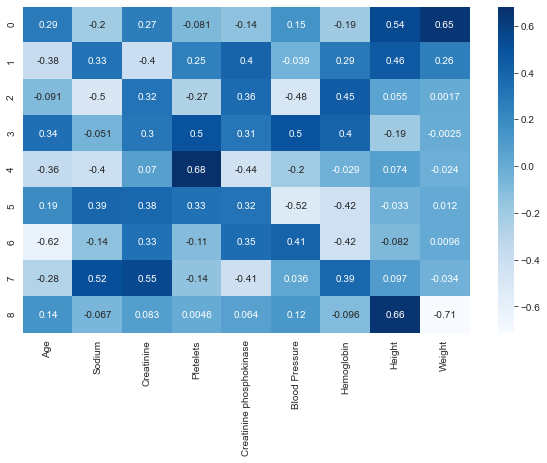

In [158]:
pca_variables = pd.DataFrame(df_pca, columns=df_pca.columns)
sb.heatmap(pca_variables, cmap='Blues', annot=True )

# Elliptic Envelope for Outlier Detection
An ellipse can be drawn around the data points based on some criteria and any data point inside the ellipse is an inlier(blue) while any outside the ellipse is an outlier(red)

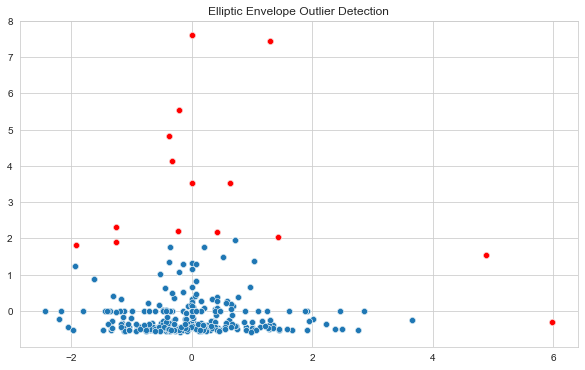

In [312]:
def elle_env(dataset, columns_to_add):
    
    dataset_new = dataset[columns_to_add].to_numpy() #convert df to array
    scaler = StandardScaler() #instantiate scale function
    dataset_normalized = scaler.fit_transform(dataset_new)
    model = EllipticEnvelope(contamination=0.05, 
                          random_state=1)

    pred = model.fit_predict(dataset_normalized)
    sb.set_style("whitegrid")

    outlier_index = np.where(pred==-1) #get outlier index
    outlier_values = dataset_normalized[outlier_index] 

    sb.set_style("whitegrid")
    #scatterplot with outliers in red
    sb.scatterplot(x=dataset_normalized[:,0], y=dataset_normalized[:,1])
    sb.scatterplot(x=outlier_values[:,0], 
                y=outlier_values[:,1], color='r')
    plt.title("Elliptic Envelope Outlier Detection")
    
    #return outlier_index
    
elle_env(df_preprocessed, ['Pletelets','Creatinine phosphokinase'])

# Random Forest Regressor

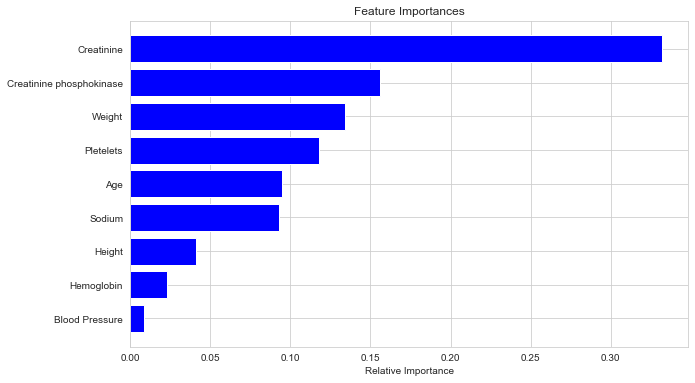

In [298]:
def rf_regressor(dataset, columns_to_drop, target):
    dataset_new = drop_columns(dataset, list(columns_to_drop))
    dataset_array = dataset_new.to_numpy()#converting dataframe to array
    scaler = StandardScaler() #instantiate scale function
    dataset_normalised = scaler.fit_transform(dataset_array) #normalizing the numerical values
    target_variable = dataset[target]
    target_reshaped = target_variable.values.reshape(-1,1).ravel() #both variables and target variables have now the same dimensions
    model = RandomForestRegressor(random_state=0, max_depth=10)
    model.fit(dataset_normalised,target_reshaped)
    
    features = dataset_new.columns
    importances = model.feature_importances_ #obtain relative importance
    indices = np.argsort(importances) #sort according to most important
    plt.title('Feature Importances')
    #plot bar graph of importance per feature
    plt.barh(range(len(importances)), importances[indices], color='b', align='center') 
    #assign y axis labels appropriately
    plt.yticks(range(len(importances)), [features[i] for i in indices]) 
    plt.xlabel('Relative Importance')
    plt.show()

#lets use the dataset with lesser column headers for the categorical variables
rf_regressor(df_replaced, ['Diabetes','Smoke','Ejection Fraction','Gender','Survive'], ['Survive'])